# CTE

In [291]:
import pandas as pd, numpy as np, scipy, re, seaborn as sns, random, pysam, sklearn, glob
sns.set()
import itertools as it
from scipy import stats, integrate, cluster
from scipy.stats import entropy, spearmanr, ttest_ind, zscore
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
from matplotlib_venn import venn2, venn3, venn3_circles, venn3_unweighted
from collections import defaultdict

from __future__ import print_function
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Mojito/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'info', 'f', 'random', 'entropy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Dataset

In [292]:
#ensembl = pd.read_csv("biomart_export_grch38p12.txt", sep='\t')
#counts = pd.read_csv('all_NumReads_counts.tsv', sep='\t')
#counts['Name'] = counts['Name'].str.split('.').str[0]
#counts['Median_counts'] = counts[list(counts)[1:]].median(axis=1)
#counts = pd.merge(ensembl[['Gene stable ID', 'Gene name']], counts, left_on='Gene stable ID', right_on='Name', how='right')
#counts = counts[['Gene stable ID','Gene name', 'Median_counts']]

CTE_info = pd.read_csv('CTE_sample_info_all.csv', sep=',', usecols=['ID','Status','SampleName','RIN', 'Seq_Batch'])
CTE_info['SampleName'] = CTE_info['SampleName'].str.replace('TS-','')
CTE_info['SampleName']=['{}-{:04d}'.format(_.split('-')[0], int(_.split('-')[1])) if 'K' in _ else _ for _ in CTE_info['SampleName']]
CTE_info['SampleName']=[ _.replace('-','') if 'BVAX' in _ else _ for _ in CTE_info['SampleName']]

CTE_info['ID'] = CTE_info['ID'].str.split('_').str[0] + '_' + CTE_info['ID'].str.split('_').str[1]
print(len(CTE_info))

86


In [293]:
u_info = pd.read_csv('RNASeqAnalysis_wDementiahx.csv', sep=',', 
                     usecols=['subjid', 'agedeath', 'npbraak', 'CTEstage', 'PathAD','PathLBD'
                             ,'agecogsx', 'totyrs' ,'Race_Self_Report'])
u_info['subjid'] =['BVAX{:03d}'.format(int(_.split('BVAX')[1])) if 'BVAX' in _ else _ for _ in u_info['subjid']]

info = pd.merge(CTE_info, u_info, left_on='SampleName', right_on='subjid', how='left')
info = info.drop(columns=['SampleName','subjid'])
info['PathLBD'] = [ '1' if _ == '0' else _ for _ in info['PathLBD']]

info = info.replace(r'\s+|^$', np.nan, regex=True)
info = info.replace(r'unk', np.nan, regex=True)
cols = list(info)[5:]
info[cols] = info[cols].apply(pd.to_numeric, errors='coerce')
info2 = info.copy()

In [294]:
cte34 = info[info['Status'] == 'CTE_34'][['ID', 'PathAD','PathLBD']]

print(len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 1)]))
print(len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 2)]))
print(len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 1)]))
print(len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 2)]))

pd.DataFrame({'LBD':['PathLBD = 1', 'PathLBD = 2'],
              'PathAD=0':[len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 1)]),
                          len(cte34[(cte34['PathAD'] == 0) & (cte34['PathLBD'] == 2)])],
             'PathAD=1':[len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 1)]),
                         len(cte34[(cte34['PathAD'] == 1) & (cte34['PathLBD'] == 2)])]}, columns=['LBD','PathAD=0','PathAD=1'])

28
7
16
2


LBD  PathAD=0  PathAD=1
0  PathLBD = 1        28        16
1  PathLBD = 2         7         2

/Users/Mojito/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x17d3a77f0>,
      dtype=object)

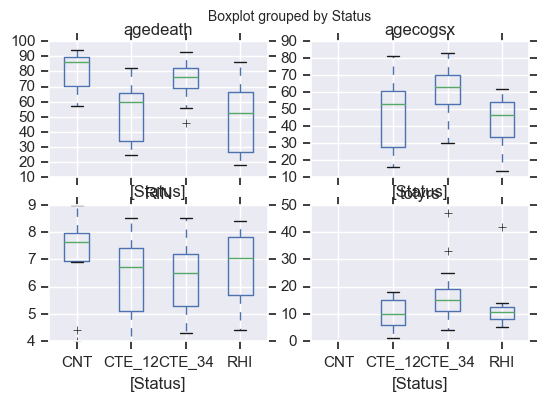

In [295]:
f, ax = plt.subplots(2,2,sharex=True)
info.boxplot(ax=ax, column=['agedeath','agecogsx','RIN','totyrs'], by=['Status'])
#info.dropna(subset=['PathAD'])

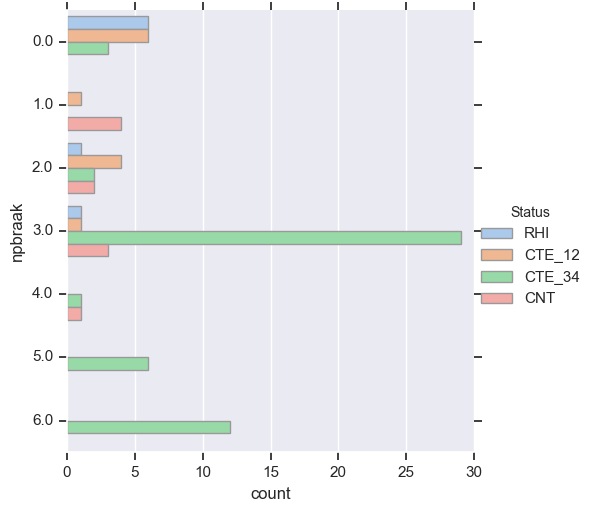

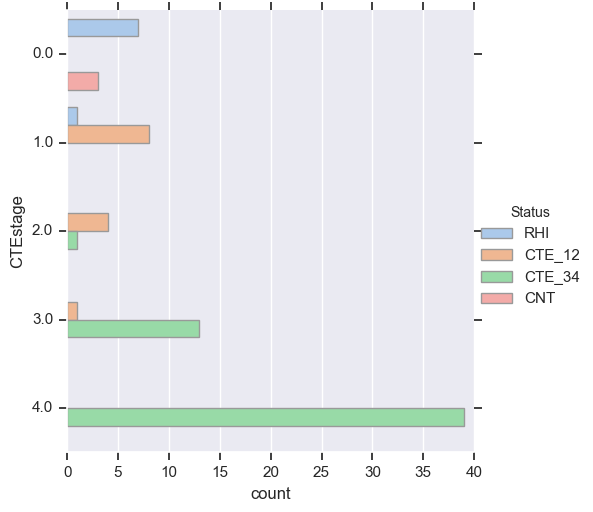

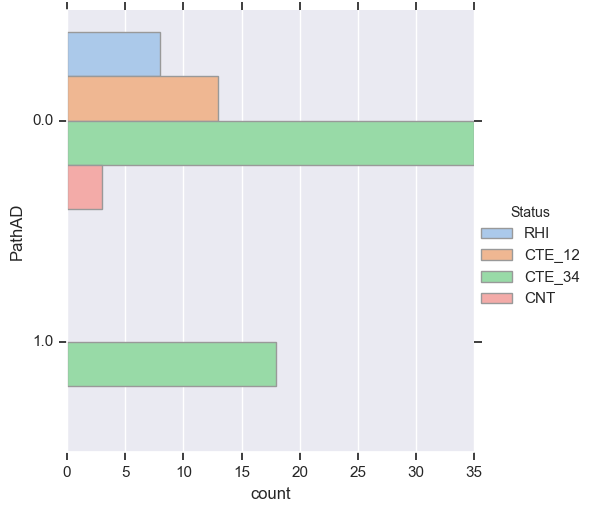

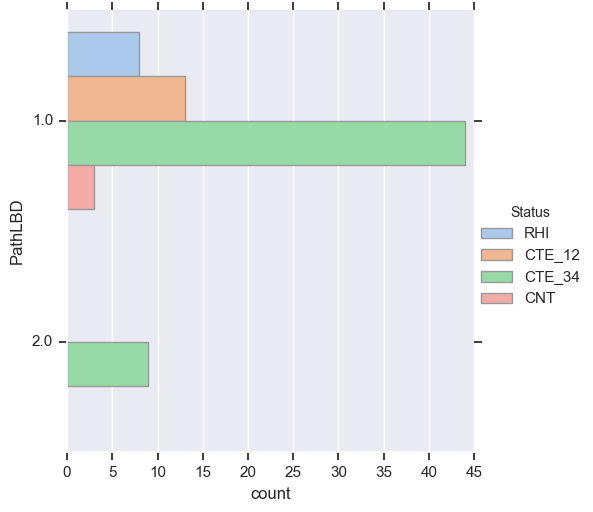

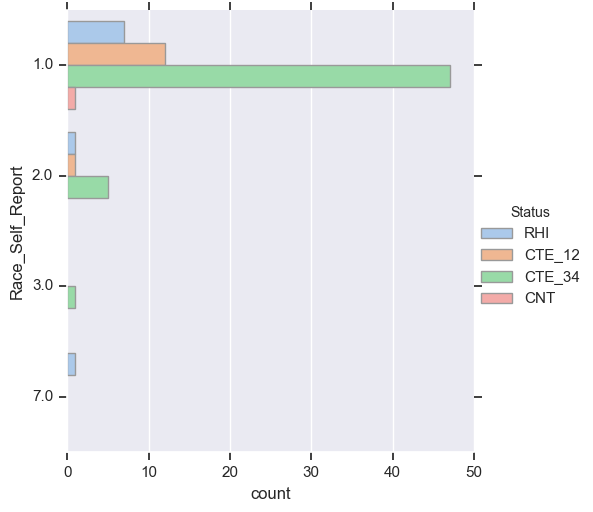

In [296]:
for column in ['npbraak', 'CTEstage', 'PathAD','PathLBD','Race_Self_Report']:
    sns.catplot(y=column, hue="Status", kind="count",palette="pastel", edgecolor=".6",data=info);

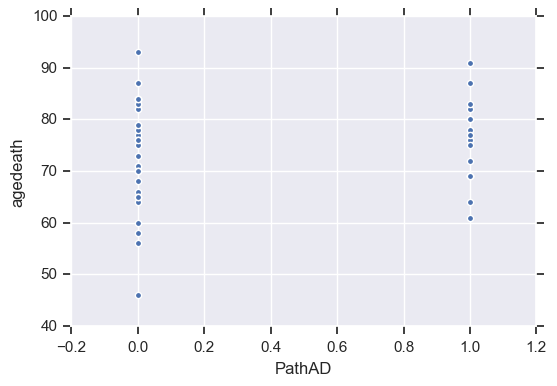

In [297]:
d = info[info['Status'] == 'CTE_34']
d.plot( x='PathAD',y='agedeath',kind='scatter')

In [365]:
#info.to_csv('CTE_sample_info_plus.csv', index=False)
#info

## TSNE

In [299]:
from sklearn.datasets import fetch_mldata
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [549]:
norm = pd.read_csv('all_NumReads_counts_filtlow_all_norm.csv', sep=',', index_col='Name')

x = norm.T
print(x.shape, len(samples), norm.shape)
genes = list(x)
x = x.merge(info, left_index=True, right_on='ID')
x = x.set_index(x['ID'])
x.index.name = None
x = x[x['Status'] != 'CNT']
print(x.shape, len(samples), norm.shape)

(85, 26538) 85 (26538, 85)
(76, 26550) 85 (26538, 85)


In [408]:
np.random.seed(42)

data = x[genes].values
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000)
tsne_results = tsne.fit_transform(data)
#print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 75 nearest neighbors...
[t-SNE] Indexed 76 samples in 0.004s...
[t-SNE] Computed neighbors for 76 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 76 / 76
[t-SNE] Mean sigma: 175935.889414
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.187866
[t-SNE] KL divergence after 1450 iterations: 0.130090


In [409]:
x['tsne-one'] = tsne_results[:,0]
x['tsne-two'] = tsne_results[:,1]

extra_cols = [ _ for _ in list(x) if 'ENSG' not in _ ]
rel_cols = ['Status','npbraak','CTEstage','PathAD','PathLBD']
cont_cols = ['agedeath','RIN','agecogsx','totyrs']

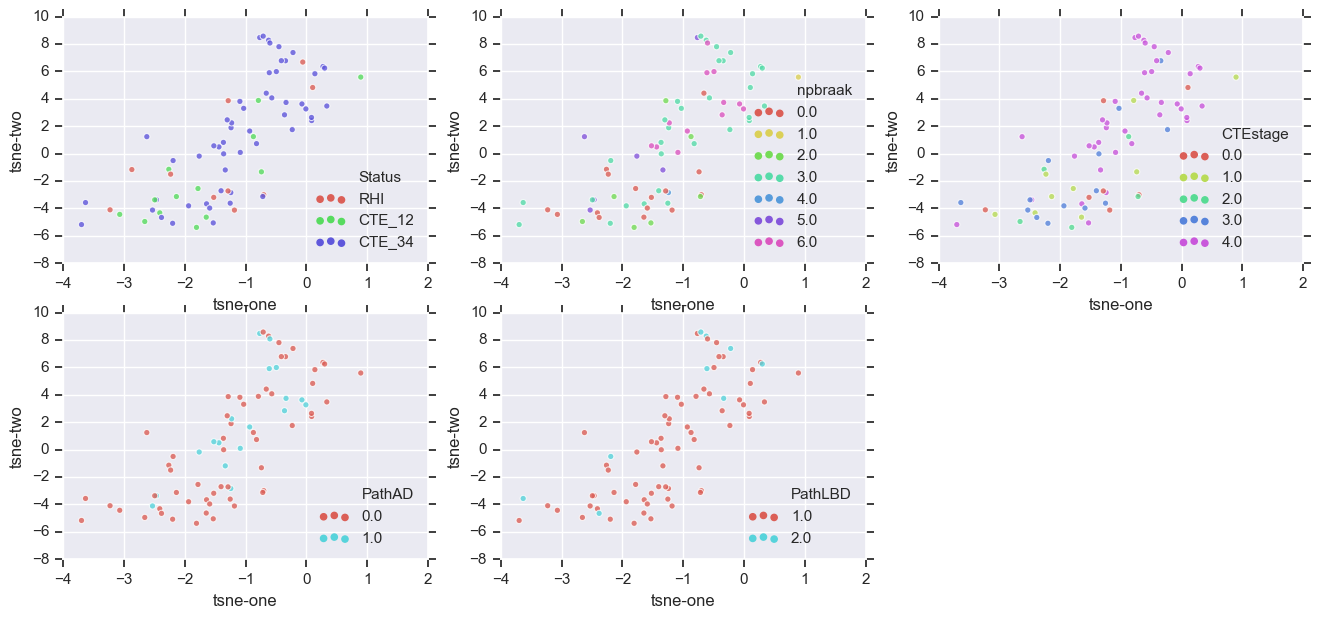

In [410]:
plt.figure(figsize=(16,7))

for i in range(len(rel_cols)):
    n = [x for x in list(x[rel_cols[i]].unique()) if str(x) != 'nan']
    ax1 = plt.subplot(2, 3, i+1)
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue=rel_cols[i],
        palette=sns.color_palette("hls", len(n)),
        data=x,
        alpha=0.8,
        ax=ax1
    )
#    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    ax1.legend(loc='lower right', frameon=False)

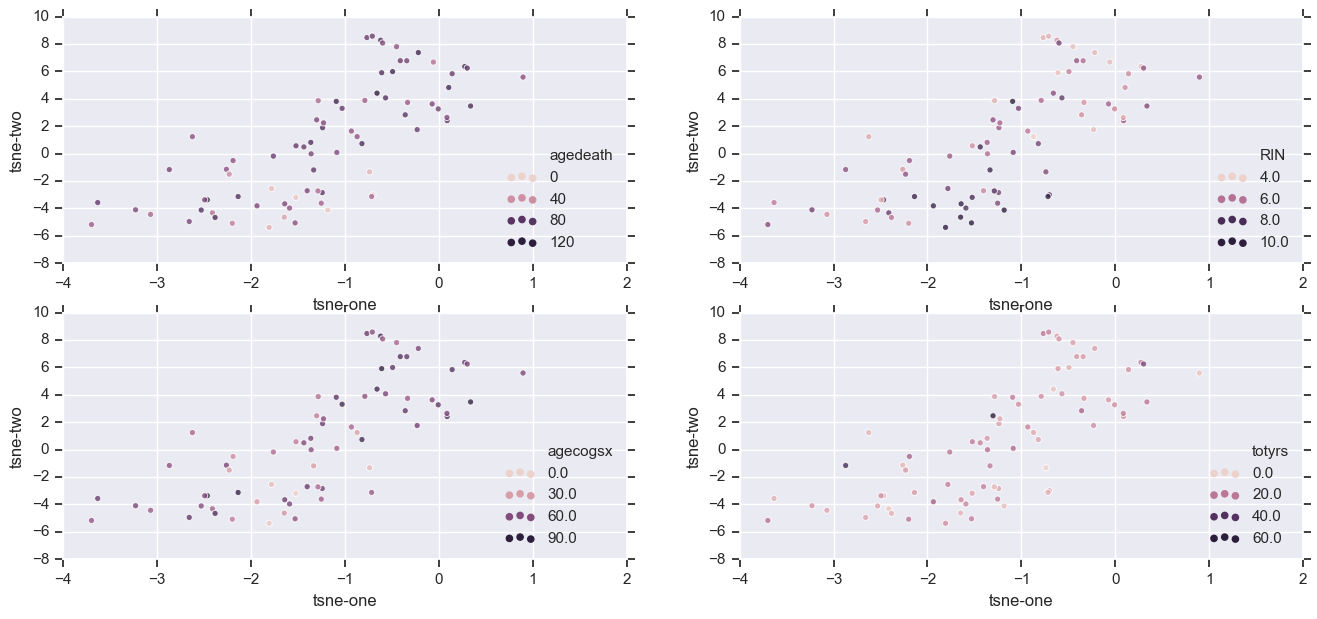

In [411]:
plt.figure(figsize=(16,7))
for i in range(len(cont_cols)):
    ax1 = plt.subplot(2, 2, i+1)
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue=cont_cols[i],
        data=x,
        alpha=0.8,
        ax=ax1
    )
    ax1.legend(loc='lower right', frameon=False)    

In [550]:
ensembl = pd.read_csv("biomart_export_grch38p12.txt", sep='\t', usecols=['Gene stable ID', 'Gene name'])
norm['Name'] = norm.index
norm['Name'] = norm['Name'].str.split('.').str[0]
norm = pd.merge(ensembl, norm, left_on='Gene stable ID', right_on='Name')
norm = norm.drop(columns=['Gene stable ID','Name'])


/Users/Mojito/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 'Name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


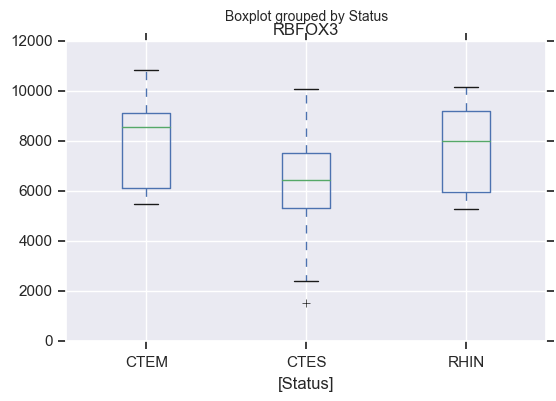

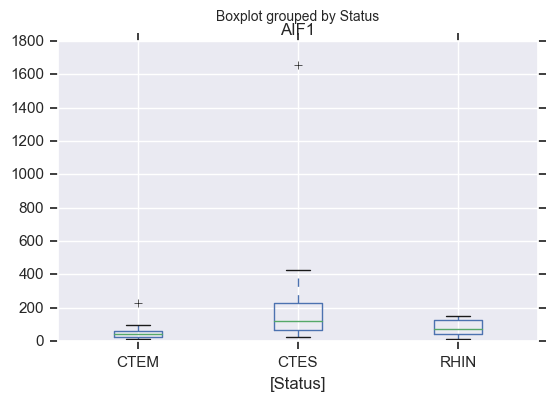

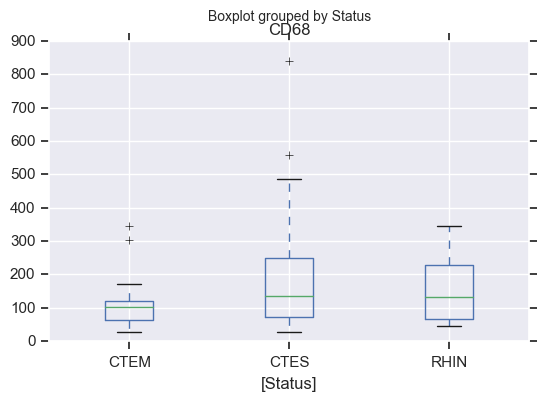

In [552]:
gene4 = ['RBFOX3','AIF1','CD68']
# Cant find AT8 or proper gene name for it
# RBFOX3 = NeuN, AIF1=IBA1
g4 = norm_nf[(norm_nf['Gene name'] == 'AIF1')|(norm_nf['Gene name'] == 'RBFOX3')|(norm_nf['Gene name'] == 'CD68')].T
g4.columns = gene4
g4['Status'] = g4.index.str[:4]
g4 = g4[1:]
g4 = g4[g4['Status']!='CNTL']
g4 = g4.reset_index()
g4[gene4] = g4[gene4].apply(pd.to_numeric, errors='coerce')

for g in gene4:
    g4.boxplot(column=[g], by=['Status'])